#ANALISIS DE ALTO CRECIMIENTO

##Importación de paquetes y carga de datos

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import missingno
import datetime
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from imblearn.combine import SMOTEENN
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score

from sklearn.model_selection import GridSearchCV #busqueda de hiperparámetros


In [ ]:
data=pd.read_csv('df_nietos2.csv')
data.head()

,Unnamed: 0,ID,CNAE,CNAE_DESCRIPCION,IMPORT_EXPORT,ULT_ACTOMERCANTIL,TAM_EMPRESA,Estado,ACC_EXTRAN,ACC_EMPRESA,...,A-17-DIF_CAMBIO_34_diff,A-17-DIF_CAMBIO_23_diff,A-17-DIF_CAMBIO_12_diff,A-20-IMPUESTOS_34_diff,A-20-IMPUESTOS_23_diff,A-20-IMPUESTOS_12_diff,Subvencion,ALTO_CRECIMIENTO_CALCU,GACELA_CALCU,MODELO_CALCU
0,0,100017,7219,Otra investigación y desarrollo experimental e...,Nada,2020-12-14 01:00:00,Microempresa,Viva,NaN,NaN,...,NaN,NaN,NaN,0.222222,inf,NaN,1,0,0,1
1,1,100017,7219,Otra investigación y desarrollo experimental e...,Nada,2020-12-14 01:00:00,Microempresa,Viva,NaN,NaN,...,NaN,NaN,NaN,0.222222,inf,NaN,1,0,0,1
2,2,100017,7219,Otra investigación y desarrollo experimental e...,Nada,2020-12-14 01:00:00,Microempresa,Viva,NaN,NaN,...,NaN,NaN,NaN,0.222222,inf,NaN,1,0,0,1
3,3,100020,2822,Fabricación de maquinaria de elevación y manip...,Nada,2019-02-04 01:00:00,Pequeña,Viva,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.084848,0.666667,1,0,0,0
4,4,100020,2822,Fabricación de maquinaria de elevación y manip...,Nada,2019-02-04 01:00:00,Pequeña,Viva,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.084848,0.666667,1,0,0,0


Hay columnas datetime que las vamos a pasar a tipo numérico, quedandonos solo con el año

In [ ]:
data['InicioActividad'] = pd.to_datetime(data['InicioActividad'])
data['ULT_ACTOMERCANTIL'] = pd.to_datetime(data['ULT_ACTOMERCANTIL'])

data['Inicio Actividad'] = data['InicioActividad'].dt.year
data.drop(columns=['InicioActividad'], inplace=True, axis=1)

data['ULT_ACTOMERCANTIL_Y'] = data['ULT_ACTOMERCANTIL'].dt.year
data.drop(columns=['ULT_ACTOMERCANTIL'], inplace=True, axis=1)

In [ ]:
data.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

##Tratamiento de datos faltantes

Lo primero que vamos a hacer va a ser realizar un tratamiento de datos faltantes.

<Axes: >

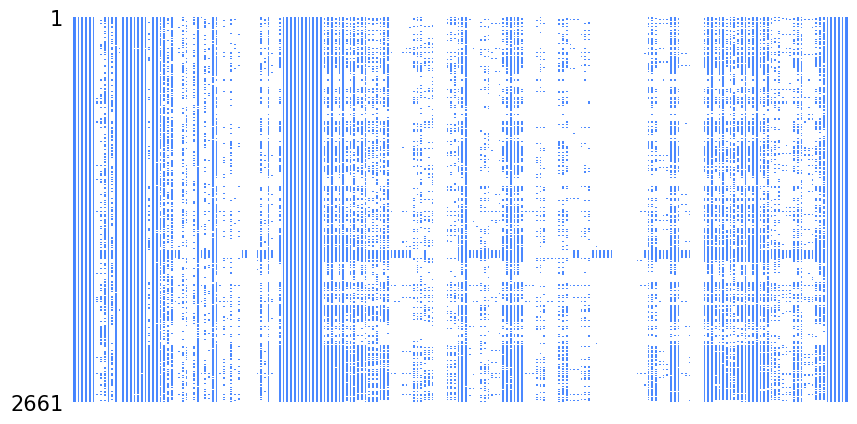

In [ ]:
missingno.matrix(data,sparkline=False, figsize=(10,5), fontsize=12, color=(0.27, 0.52, 1.0))

In [ ]:
# Calculamos el porcentaje de missing values para cada atributo
percent_missing = data.isnull().sum() *100 / len(data)
# Creamos un DataFrame con los porcentajes y el nombre de cada atributo
missing_values_df = pd.DataFrame({'percent_missing': percent_missing})

Como se puede observar, hay una gran cantidad de datos faltantes.

Empezamos eliminando las diferencias de años 34 ya que al hacer la predicción, las nuevas empresas no van a tener dichos registros, sino ya sabríamos si son empresas de alto crecimiento o no.

In [ ]:
data2=data.copy()

In [ ]:
remove=[]
for col in data.columns:
  if '_34' in col:
    remove.append(col)
data2.drop(columns=remove, axis=1, inplace=True)

Todas las columnas referentes a datos del balance o de la cuenta de resultados que tengan datos nulos, se deberá a que dichos datos serán 0. Procedemos a rellenar esos datos con 0.

In [ ]:
df_missing = missing_values_df.T
columnas=list(df_missing.columns)
for col in columnas:
  if '_1' in col or '_2' in col:
    data2[col] = data[col].fillna(0)

A continuación vemos qué columnas siguen teniendo datos faltantes para realizar el tratamiento de missing de dichas columnas

In [ ]:
#Columnas que siguen teniendo datos faltantes

# Calculamos el porcentaje de missing values para cada atributo
percent_missing = data2.isnull().sum() *100 / len(data2)
# Creamos un DataFrame con los porcentajes y el nombre de cada atributo
missing_values_df = pd.DataFrame({'percent_missing': percent_missing})
# Atributos con algun missing value
missing_values_df[missing_values_df['percent_missing'] > 0]

,percent_missing
ACC_EXTRAN,95.415257
ACC_EMPRESA,71.063510
NUMACCIONISTAS,44.832770
ACT_MEDIOS,53.776776
CARGOS_ADMIN,0.150319
ESTRUCTURA,98.759865
AÑO CONCESION,0.450958
IMPORTE NOMINAL,0.413378
DESCRIPCIÓN,0.450958
ORGANISMO,0.714017


Las tres primeras columnas (ACC_EXTRAN, ACC_EMPRESA, NUMACCIONISTAS) se refieren al número de accionistas extranjeros, que son empresas, y el número total respectivamente. Si hay datos faltantes significa que no hay accionistas por lo que se procede a rellenar los datos faltantes con 0.

La columna de ACT_MEDIOS se refiere a si la empresa está activa en medios, si hay datos faltantes, la empresa no estará activa en medios, por lo que se procede a rellenar con un 'NO' los datos faltantes.

CARGOS_ADMIN se refiere al número registrado de administradores. Mínimo debería haber 1, por lo que rellenamos los datos faltantes con un 1.

La columna de ESTRUCTURA tiene casi todos sus datos faltantes, por lo que se elimina dicha columna.

El AÑO CONCESIÓN, IMPORTE NOMINAL, DESCRIPCIÓN y ORGANISMO se refieren a la subvención. Si hay datos nulo significa que no se ha recibido subvención por lo que el AÑO CONCESIÓN y el IMPORTE NOMINAL se rellena con 0, el ORGANISMO se rellena con 'Ninguno' y la DESCRIPCIÓN se puede eliminar.

El Bal5 (Balance 5) y las ventas final se pueden eliminar.

In [ ]:
data2['ACC_EXTRAN']=data2['ACC_EXTRAN'].fillna(0)
data2['ACC_EMPRESA']=data2['ACC_EMPRESA'].fillna(0)
data2['NUMACCIONISTAS']=data2['NUMACCIONISTAS'].fillna(0)
data2['ACT_MEDIOS']=data2['ACT_MEDIOS'].fillna('NO')
data2['CARGOS_ADMIN']=data2['CARGOS_ADMIN'].fillna(1)
data2['IMPORTE NOMINAL']=data2['IMPORTE NOMINAL'].fillna(0)
data2['AÑO CONCESION']=data2['AÑO CONCESION'].fillna(0)
data2['ORGANISMO']=data2['ORGANISMO'].fillna('Ninguno')

data2.drop(columns=['ESTRUCTURA', 'DESCRIPCIÓN', 'Bal5'], axis=1, inplace=True)

Guardamos el nuevo dataset

In [ ]:
data2.to_csv('data2.csv')

Eliminamos la columna de VENTAS_FINAL para el modelo de clasificación de empresas de alto crecimiento

In [ ]:
data2.drop(columns=['VENTAS_FINAL'], axis=1, inplace=True)

Comprobamos que ya no hay datos faltantes

<Axes: >

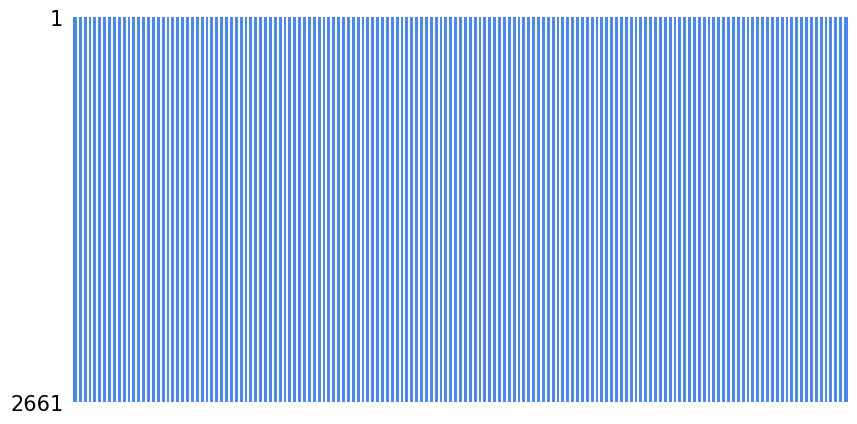

In [ ]:
missingno.matrix(data2,sparkline=False, figsize=(10,5), fontsize=12, color=(0.27, 0.52, 1.0))

##Análisis de datos categóricos

###Startups Gacela

In [ ]:
gacelas=data2[data2['GACELA_CALCU']==1]
gacela_categ=gacelas.select_dtypes(include='object')
gacela_categ.describe().T

,count,unique,top,freq
CNAE_DESCRIPCION,10,4,Telecomunicaciones por cable,5
IMPORT_EXPORT,10,2,Nada,9
TAM_EMPRESA,10,2,Microempresa,8
Estado,10,1,Viva,10
INFO_ADMIN,10,1,SI,10
ACT_MEDIOS,10,2,NO,9
MUJERES_CONSEJO,10,1,NO,10
frmJuridica,10,2,B,9
ORGANISMO,10,7,ANDALUCIA - DIRECCION GENERAL DE POLITICAS ACT...,4


A continuación vamos a ver la frecuencia de los datos para cada variable categórica

<ipython-input-17-82d161a564b7>:12: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


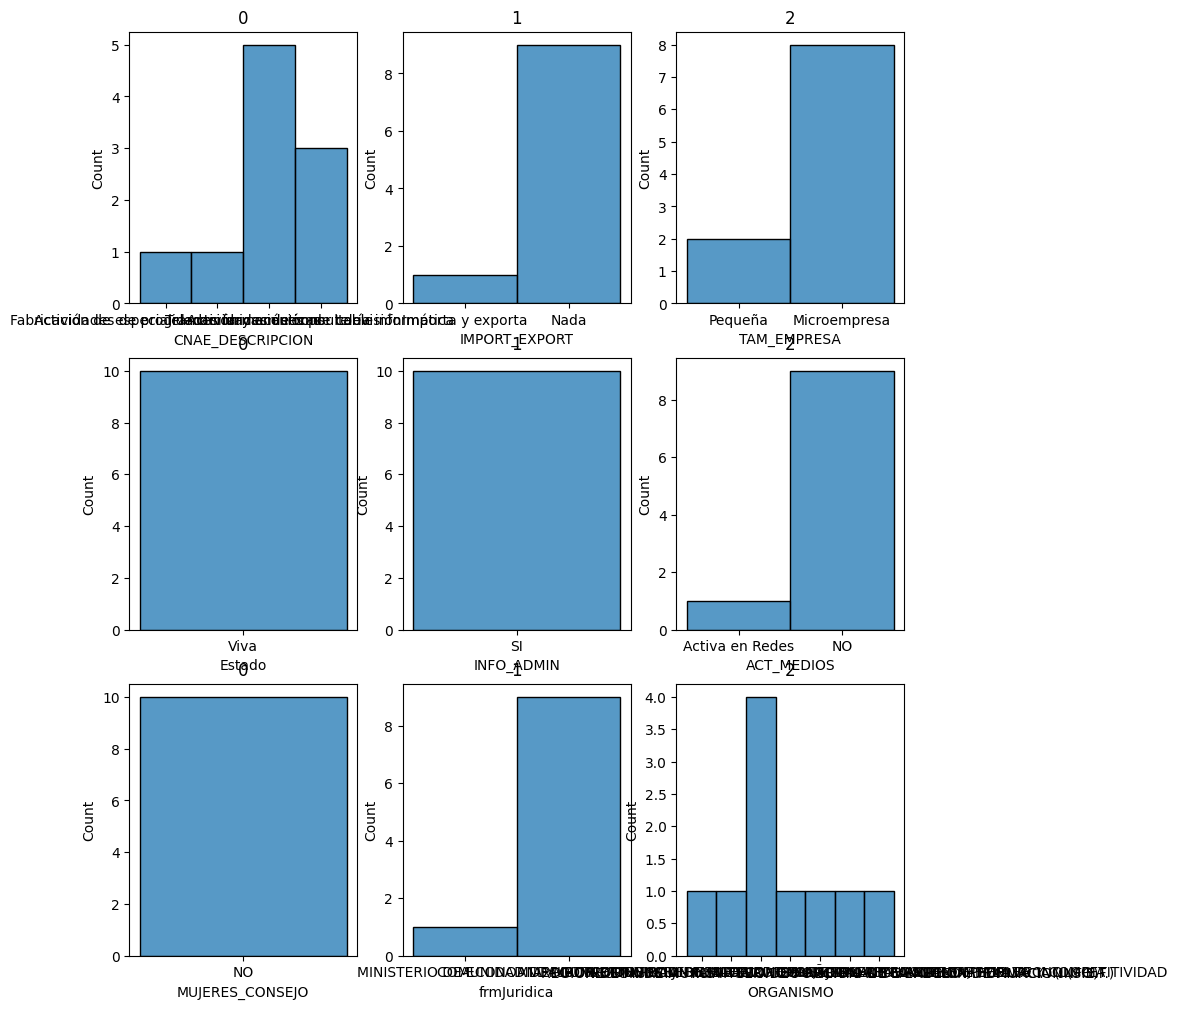

In [ ]:
columnas=list(gacela_categ.columns)

fig, axs = plt.subplots(3, 3, figsize=(10,12))

for i in range(len(columnas)):
    row = i // 3  # Calculamos la fila del subplot
    col = i % 3   # Calculamos la columna del subplot
    var=columnas[i]
    sns.histplot(x = gacela_categ[var], ax=axs[row, col])
    axs[row, col].set_title(col)

plt.tight_layout()
plt.show()

In [ ]:
for col in columnas:
  print(gacela_categ[col].value_counts())
  print('-'*20)

Telecomunicaciones por cable                           5
Actividades de consultoría informática                 3
Fabricación de especialidades farmacéuticas            1
Actividades de programación y emisión de televisión    1
Name: CNAE_DESCRIPCION, dtype: int64
--------------------
Nada                 9
Importa y exporta    1
Name: IMPORT_EXPORT, dtype: int64
--------------------
Microempresa    8
Pequeña         2
Name: TAM_EMPRESA, dtype: int64
--------------------
Viva    10
Name: Estado, dtype: int64
--------------------
SI    10
Name: INFO_ADMIN, dtype: int64
--------------------
NO                 9
Activa en Redes    1
Name: ACT_MEDIOS, dtype: int64
--------------------
NO    10
Name: MUJERES_CONSEJO, dtype: int64
--------------------
B    9
A    1
Name: frmJuridica, dtype: int64
--------------------
ANDALUCIA - DIRECCION GENERAL DE POLITICAS ACTIVAS DE EMPLEO                                    4
COMUNIDAD DE MADRID - CONSEJERIA DE ECONOMIA, EMPLEO Y HACIENDA                

### Startups de alto crecimiento

In [ ]:
alto_crec=data2[data2['ALTO_CRECIMIENTO_CALCU']==1]
alto_crec_categ=alto_crec.select_dtypes(include='object')
alto_crec_categ.describe().T

,count,unique,top,freq
CNAE_DESCRIPCION,231,28,Actividades de programación informática,35
IMPORT_EXPORT,231,4,Nada,197
TAM_EMPRESA,231,2,Microempresa,213
Estado,231,1,Viva,231
INFO_ADMIN,231,1,SI,231
ACT_MEDIOS,231,4,NO,96
MUJERES_CONSEJO,231,2,NO,204
frmJuridica,231,2,B,227
ORGANISMO,231,60,"MINISTERIO DE INDUSTRIA, COMERCIO Y TURISMO - ...",27


A continuación vamos a ver la frecuencia de los valores para variable categórica

<ipython-input-20-92dc95dfed06>:12: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


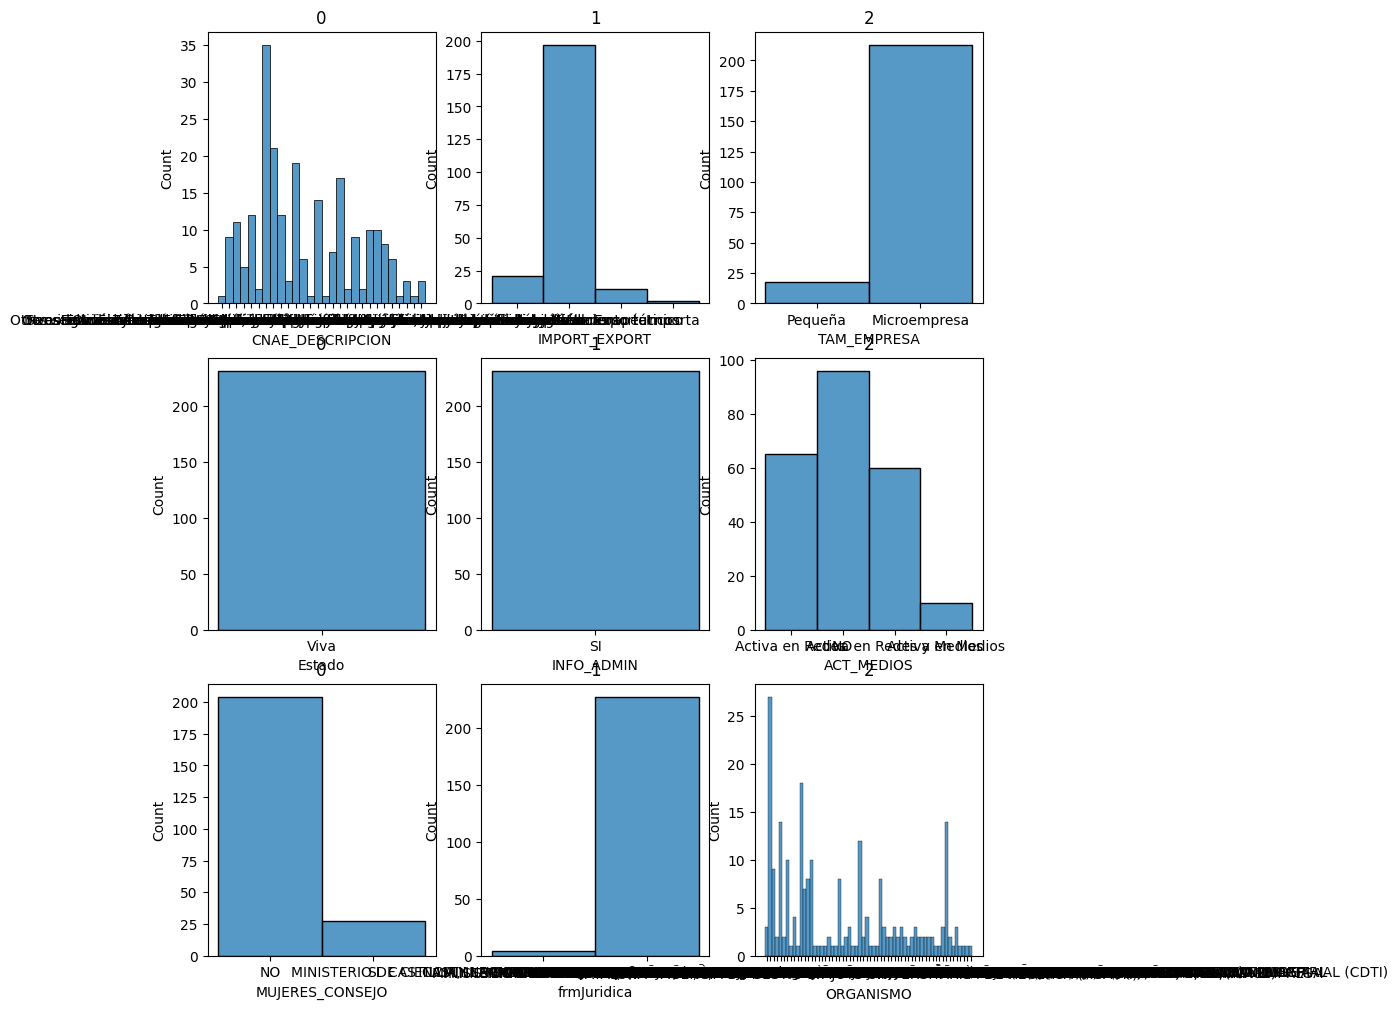

In [ ]:
columnas=list(alto_crec_categ.columns)

fig, axs = plt.subplots(3, 3, figsize=(10,12))

for i in range(len(columnas)):
    row = i // 3  # Calculamos la fila del subplot
    col = i % 3   # Calculamos la columna del subplot
    var=columnas[i]
    sns.histplot(x = alto_crec_categ[var], ax=axs[row, col])
    axs[row, col].set_title(col)

plt.tight_layout()
plt.show()

In [ ]:
for col in columnas:
  print(alto_crec_categ[col].value_counts())
  print('-'*20)

Actividades de programación informática                                                           35
Fabricación de otra maquinaria para usos específicos n.c.o.p.                                     21
Otros servicios relacionados con las tecnologías de la información y la informática               19
Otra investigación y desarrollo experimental en ciencias naturales y técnicas                     17
Otros servicios de información n.c.o.p.                                                           14
Actividades de consultoría informática                                                            12
Telecomunicaciones por cable                                                                      12
Otras actividades profesionales, científicas y técnicas n.c.o.p.                                  11
Fabricación de envases y embalajes de plástico                                                    10
Investigación y desarrollo experimental en biotecnología                                   

##Datos numéricos

###Startups Gacela

In [ ]:
gacela_num=gacelas.select_dtypes(exclude='object')
gacela_num.describe().T

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4489: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4489: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,count,mean,std,min,25%,50%,75%,max
ID,10.0,108668.5,7002.163273,100081.0,104173.0,104173.0,114985.0,120784.0
CNAE,10.0,5729.6,1269.582188,2120.0,6110.0,6110.0,6179.0,6202.0
ACC_EXTRAN,10.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
ACC_EMPRESA,10.0,0.1,0.316228,0.0,0.0,0.0,0.0,1.0
NUMACCIONISTAS,10.0,0.2,0.421637,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
ALTO_CRECIMIENTO_CALCU,10.0,1.0,0.000000,1.0,1.0,1.0,1.0,1.0
GACELA_CALCU,10.0,1.0,0.000000,1.0,1.0,1.0,1.0,1.0
MODELO_CALCU,10.0,1.0,0.000000,1.0,1.0,1.0,1.0,1.0
Inicio Actividad,10.0,2016.1,0.316228,2016.0,2016.0,2016.0,2016.0,2017.0


Como hay demasiadas columnas no se puede ver nada con claridad, por lo que vamos a realizar una correlación con la variables GACELA_CALCU.

In [ ]:
corr_gacela = data2.corr(method='pearson')
corr_gacela[['GACELA_CALCU']].sort_values(by = 'GACELA_CALCU',ascending = False)\
.style.background_gradient()

<ipython-input-23-486c55159343>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_gacela = data2.corr(method='pearson')


,GACELA_CALCU
GACELA_CALCU,1.000000
A-I-INM_INT_23_diff,0.286024
ALTO_CRECIMIENTO_CALCU,0.199201
C-III-DEU_CP_23_diff,0.081461
MODELO_CALCU,0.060524
A-V-INV_FLP_23_diff,0.041066
A-20-IMPUESTOS_12_diff,0.028957
A-II-INM_MAT_23_diff,0.024538
ROA_1,0.020146
B-III-DEU_GRU_LP_23_diff,0.016585


###Startups de alto crecimiento

In [ ]:
alto_crec_num=alto_crec.select_dtypes(exclude='object')
alto_crec_num.describe().T

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4488: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


,count,mean,std,min,25%,50%,75%,max
ID,231.0,113171.246753,6454.169952,100017.0,106711.0,113050.0,120636.0,121847.0
CNAE,231.0,5697.567100,1574.045462,2042.0,5915.0,6201.0,6399.0,7490.0
ACC_EXTRAN,231.0,0.021645,0.145838,0.0,0.0,0.0,0.0,1.0
ACC_EMPRESA,231.0,0.445887,1.177827,0.0,0.0,0.0,0.0,8.0
NUMACCIONISTAS,231.0,1.069264,1.889205,0.0,0.0,1.0,1.0,11.0
...,...,...,...,...,...,...,...,...
ALTO_CRECIMIENTO_CALCU,231.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
GACELA_CALCU,231.0,0.043290,0.203951,0.0,0.0,0.0,0.0,1.0
MODELO_CALCU,231.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
Inicio Actividad,231.0,2016.108225,0.438844,2014.0,2016.0,2016.0,2016.0,2017.0


Como hay demasiadas columnas, no se puede ver nada con claridad, por lo que vamos a quedarnos solo con las de mayor correlación

In [ ]:
corr_altoCrec = data2.corr(method='pearson')
corr_altoCrec[['ALTO_CRECIMIENTO_CALCU']].sort_values(by = 'ALTO_CRECIMIENTO_CALCU',ascending = False)\
.style.background_gradient()

<ipython-input-25-8e12d02be368>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_altoCrec = data2.corr(method='pearson')


,ALTO_CRECIMIENTO_CALCU
ALTO_CRECIMIENTO_CALCU,1.000000
MODELO_CALCU,0.303835
EMP_23_diff,0.264721
GACELA_CALCU,0.199201
A-15-GAS_FIN_12_diff,0.163558
C-VI-PER_CP_23_diff,0.152744
B-II-EXISTENCIAS_12_diff,0.106126
EMP_12_diff,0.099106
B-III-DEU_COM_23_diff,0.087560
ID,0.081657


##Preprocesamiento de los datos


En general, es recomendable abordar el problema de los datos desbalanceados antes de considerar la reducción de la dimensionalidad. Esto se debe a que el desbalanceo de los datos puede afectar significativamente el rendimiento del modelo de aprendizaje automático, lo que puede llevar a una menor precisión y a resultados insatisfactorios.

Por lo tanto, es importante aplicar técnicas de equilibrado de clases, como la submuestreo, sobremuestreo o combinaciones de ambas antes de aplicar la reducción de dimensionalidad. Estas técnicas pueden ayudar a que el modelo tenga una visión más equilibrada de las clases subrepresentadas y, por lo tanto, mejorar su capacidad para aprender patrones y características relevantes.

Una vez que se haya abordado el desbalanceo de los datos, se puede considerar la reducción de dimensionalidad si se cree que la gran cantidad de columnas puede estar causando ruido o redundancia en los datos. Sin embargo, es importante tener en cuenta que la reducción de dimensionalidad puede implicar la pérdida de información importante y, en algunos casos, puede incluso empeorar el rendimiento del modelo. Por lo tanto, se debe realizar un análisis cuidadoso antes de aplicar esta técnica y evaluar el impacto en la precisión del modelo.

Lo primero de todo, se van a eliminar las columnas relacionadas con las ventas, ya que el alto crecimiento de una empresa depende completamente de ellas. Así podemos ver otros factores que intervienen en el alto crecimiento de una empresa.

In [33]:
#data2=pd.read_csv('data2.csv')
#data2.drop(columns=['VENTAS_FINAL', 'Unnamed: 0'], axis=1, inplace=True)

In [34]:
eliminar=[]
for col in data2:
  if 'VENTA' in col:
    eliminar.append(col)
data2.drop(columns=eliminar, axis=1, inplace=True)

Nos quedamos con los datos del modelo

In [35]:
modelo_clasif=data2[data2['MODELO_CALCU']==1]

In [36]:
#otras columnas a eliminar
modelo_clasif.drop(columns=['GACELA_CALCU', 'MODELO_CALCU', 'CNAE_DESCRIPCION', 'ID', 'ORGANISMO'], axis=1, inplace=True)

<ipython-input-36-44674dd110eb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  modelo_clasif.drop(columns=['GACELA_CALCU', 'MODELO_CALCU', 'CNAE_DESCRIPCION', 'ID', 'ORGANISMO'], axis=1, inplace=True)


convertimos las variables categóricas en numéricas

In [37]:
modelo2=pd.get_dummies(modelo_clasif)

Separamos la variable target

In [38]:
cols = list(modelo2.columns)
cols.remove("ALTO_CRECIMIENTO_CALCU") 
X = modelo2[cols].values
# Variable a predecir: 
Y = modelo2['ALTO_CRECIMIENTO_CALCU']

Comprobamos si hay datos infinitos

In [39]:
# Check for infinite values
print(np.isfinite(X).all())

False


In [40]:
X = np.nan_to_num(X, nan=0, posinf=1e9, neginf=-1e9)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

**Técnica de desbalanceo de datos**: La técnica que mejores resultados ofrecía era la combinación de subsampling de la clase mayoritaria y oversamplig de la clase minoritaria, por lo que es la técnica que vamos a utilizar.

In [41]:
# Crear objeto SMOTEENN
smote_enn = SMOTEENN(random_state=0)

# Aplicar SMOTEENN a los datos de entrenamiento
X_resampled, y_resampled = smote_enn.fit_resample(X, Y)

##Reducción de la dimensionalidad

Se va a realizar una comparativa entre dos modelos de clasificación utilizando un árbol de decisión para ver si es conveniente utilizar dicha técnica o no. 

###Modelo sin PCA

In [42]:
# Division of dataset
X_train_sm, X_test_sm, Y_train_sm, Y_test_sm = train_test_split(X_resampled, y_resampled, test_size = 0.15, random_state = 42)
X_train_sm, X_val_sm, Y_train_sm, Y_val_sm = train_test_split(X_train_sm, Y_train_sm, test_size = 0.15, random_state = 42)

Búsqueda de hiperparámetros

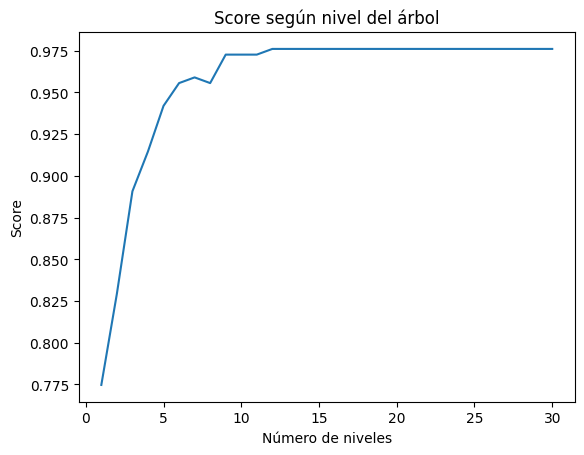

In [ ]:
#vemos profundidad del árbol
class_tree = tree.DecisionTreeClassifier(random_state=42)
scores = []
num_variables = len(X_resampled)
n_niveles = range(1, num_variables + 1)


for n in n_niveles:
    class_tree.set_params(max_depth = n)
    class_tree.fit(X_train_sm, Y_train_sm)
    scores.append(class_tree.score(X_test_sm, Y_test_sm))
    
plt.title("Score según nivel del árbol")
plt.xlabel("Número de niveles")
plt.ylabel("Score")
plt.plot(n_niveles[0:30], scores[0:30])
plt.show()


In [ ]:
print('Con {} niveles se obtuvo el mayor score'.format(np.argmax(scores)))

Con 11 niveles se obtuvo el mayor score


Entrenamiento del modelo y evaluación del mismo

In [43]:
# Entrenamiento
class_tree1 = tree.DecisionTreeClassifier(random_state=42,max_depth = 11)
class_tree1.fit(X_train_sm, Y_train_sm)

# Realizamos la predicción
Y_pred_test = class_tree1.predict(X_test_sm)
y_pred_val=class_tree1.predict(X_val_sm)

Test Accuracy: 0.9491525423728814
Test Recall: 0.9578947368421052
Validation Accuracy: 0.9666666666666667
Validation Recall: 0.9879518072289156
Matriz de confusión:


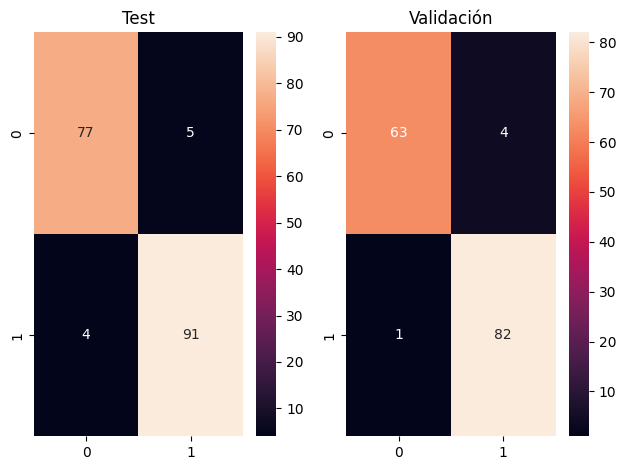

In [44]:
# Evaluamos la prediccion utilizando las metricas
acc=accuracy_score(Y_test_sm, Y_pred_test)
recall=recall_score(Y_test_sm, Y_pred_test)
conf_mat=confusion_matrix(Y_test_sm,Y_pred_test)

val_acc = accuracy_score(Y_val_sm, y_pred_val)
val_recall=recall_score(Y_val_sm, y_pred_val)
val_conf_mat=confusion_matrix(Y_val_sm,y_pred_val)


print("Test Accuracy: {}".format(acc))
print("Test Recall: {}".format(recall))
print("Validation Accuracy: {}".format(val_acc))
print("Validation Recall: {}".format(val_recall))

print("Matriz de confusión:")

fig, axs = plt.subplots(1, 2)

sns.heatmap(conf_mat, annot=True, ax=axs[0])
axs[0].set_title('Test')

sns.heatmap(val_conf_mat, annot=True, ax=axs[1])
axs[1].set_title('Validación')

plt.tight_layout()
plt.show()

Vemos las divisiones de forma gráfica

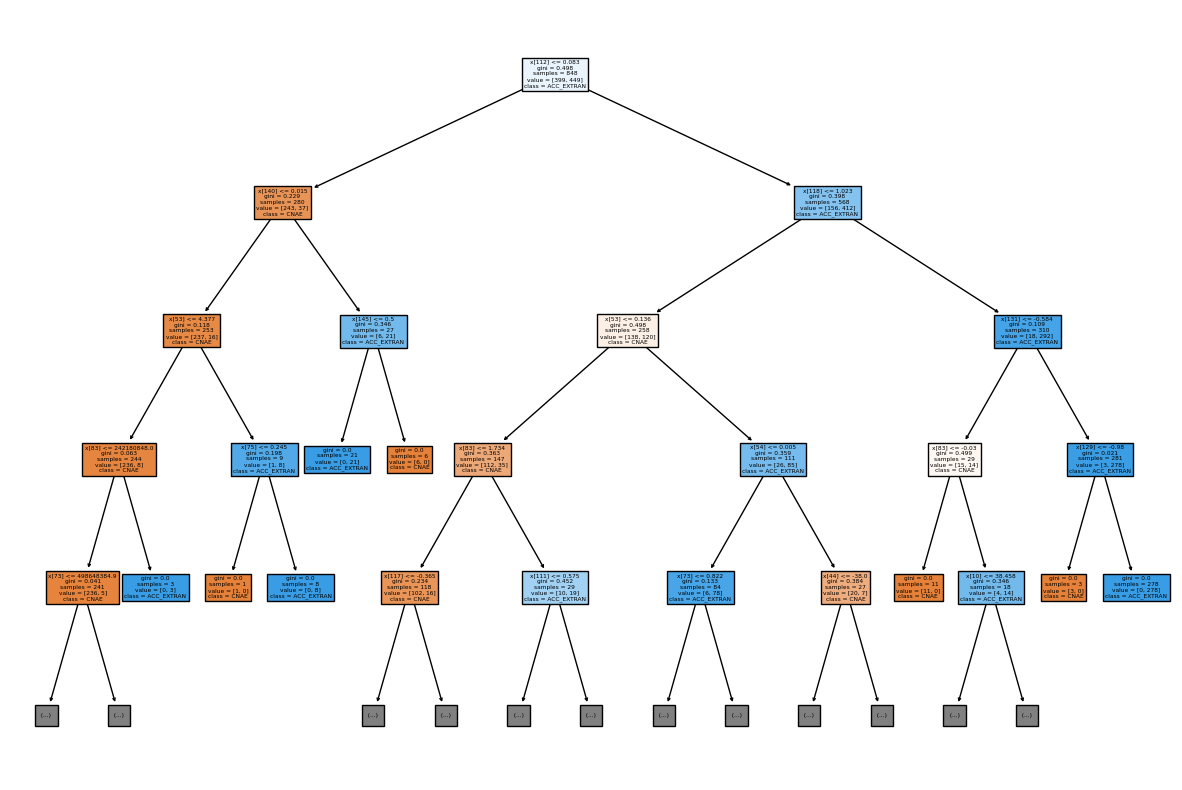

In [45]:
#Graficamente
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(class_tree1,filled=True, max_depth=4, class_names=cols)

###Modelo con PCA

primero vemos qué número de componentes es el óptimo mediante el gráfico del codo.

El número de componentes principales se selecciona en el punto donde se produce el "codo" en la curva. Esto significa que los primeros componentes explican la mayoría de la varianza en los datos y son los que deben ser retenidos para la reducción de la dimensionalidad.

In [ ]:
pca = PCA()
pca.fit(X_resampled)
eigenvalues = pca.explained_variance_

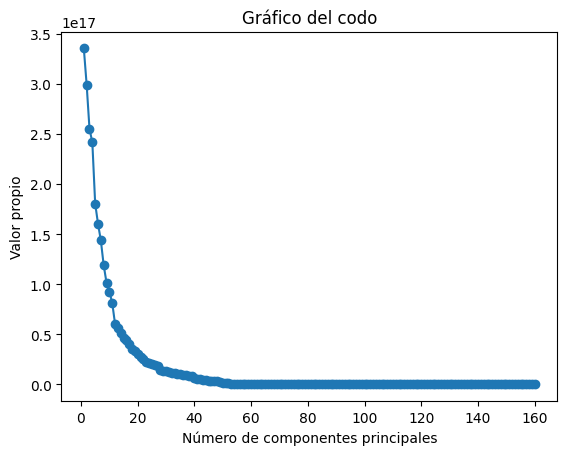

In [ ]:
num_components = list(range(1, len(eigenvalues)+1))
plt.plot(num_components, eigenvalues, marker='o')
plt.xlabel('Número de componentes principales')
plt.ylabel('Valor propio')
plt.title('Gráfico del codo')
plt.show()


In [ ]:
idx = np.argmax(np.diff(eigenvalues))
num_components = idx + 1

print(f"El número óptimo de componentes principales es {num_components}")

El número óptimo de componentes principales es 137


In [ ]:
pca = PCA(n_components=137)
 
pca_features = pca.fit_transform(X_resampled)

Nuevo árbol de clasificación

In [ ]:
# Division of dataset
X_train_pca, X_test_pca, Y_train_pca, Y_test_pca = train_test_split(pca_features, y_resampled, test_size = 0.15, random_state = 42)
X_train_pca, X_val_pca, Y_train_pca, Y_val_pca = train_test_split(X_train_pca, Y_train_pca, test_size = 0.15, random_state = 42)

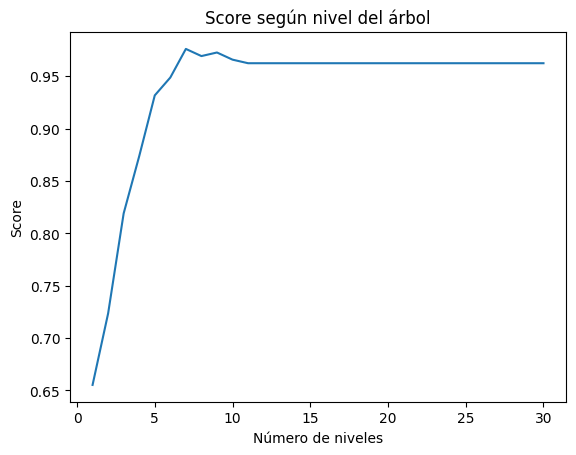

In [ ]:
#vemos profundidad del árbol
class_tree = tree.DecisionTreeClassifier(random_state=42)
scores = []
num_variables = len(pca_features)
n_niveles = range(1, num_variables + 1)


for n in n_niveles:
    class_tree.set_params(max_depth = n)
    class_tree.fit(X_train_pca, Y_train_pca)
    scores.append(class_tree.score(X_test_pca, Y_test_pca))
    
plt.title("Score según nivel del árbol")
plt.xlabel("Número de niveles")
plt.ylabel("Score")
plt.plot(n_niveles[0:30], scores[0:30])
plt.show()


In [ ]:
print('Con {} niveles se obtuvo el mayor score'.format(np.argmax(scores)))

Con 6 niveles se obtuvo el mayor score


Entrenamiento y evaluación del modelo

In [ ]:
# Entrenamiento
class_tree2 = tree.DecisionTreeClassifier(random_state=42,max_depth = 6)
class_tree2.fit(X_train_pca, Y_train_pca)

# Realizamos la predicción
Y_pred_test2 = class_tree2.predict(X_test_pca)
y_pred_val2=class_tree2.predict(X_val_pca)

Test Accuracy: 0.9488054607508533
Test Recall: 0.9612903225806452
Validation Accuracy: 0.9357429718875502
Validation Recall: 0.9444444444444444
Matriz de confusión:


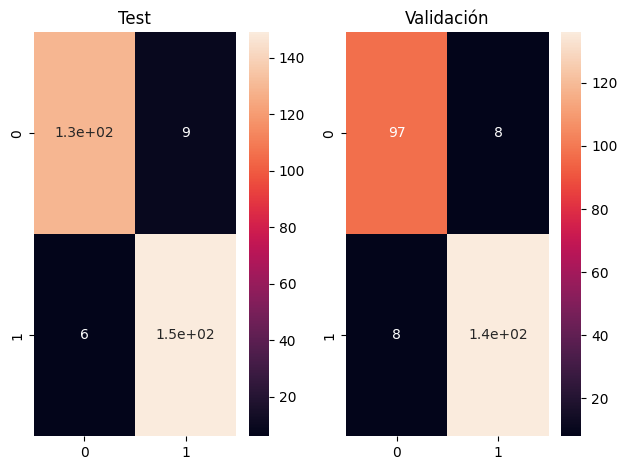

In [ ]:
# Evaluamos la prediccion utilizando las metricas
acc2=accuracy_score(Y_test_pca, Y_pred_test2)
recall2=recall_score(Y_test_pca, Y_pred_test2)
conf_mat2=confusion_matrix(Y_test_pca,Y_pred_test2)

val_acc2 = accuracy_score(Y_val_pca, y_pred_val2)
val_recall2=recall_score(Y_val_pca, y_pred_val2)
val_conf_mat2=confusion_matrix(Y_val_pca,y_pred_val2)


print("Test Accuracy: {}".format(acc2))
print("Test Recall: {}".format(recall2))
print("Validation Accuracy: {}".format(val_acc2))
print("Validation Recall: {}".format(val_recall2))

print("Matriz de confusión:")

fig, axs = plt.subplots(1, 2)

sns.heatmap(conf_mat2, annot=True, ax=axs[0])
axs[0].set_title('Test')

sns.heatmap(val_conf_mat2, annot=True, ax=axs[1])
axs[1].set_title('Validación')

plt.tight_layout()
plt.show()

###Comparativa con PCA y sin PCA

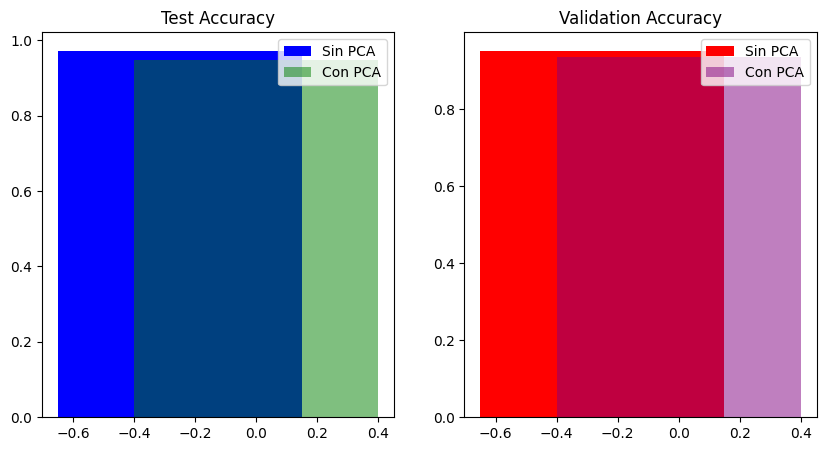

In [ ]:
# Crear los subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Crear un array de índices para las posiciones de las barras
x = np.arange(0.5)
width = 0.25

# Graficar las variables en las gráficas correspondientes
axs[0].bar(x - width,acc, color='blue', label='Sin PCA')
axs[0].bar(x,acc2, color='green', alpha=0.5, label='Con PCA')
axs[0].set_title('Test Accuracy')
axs[0].legend()

axs[1].bar(x - width,val_acc, color='red', label='Sin PCA')
axs[1].bar(x,val_acc2, color='purple', alpha=0.5, label='Con PCA')
axs[1].set_title('Validation Accuracy')
axs[1].legend()

# Mostrar la gráfica
plt.show()

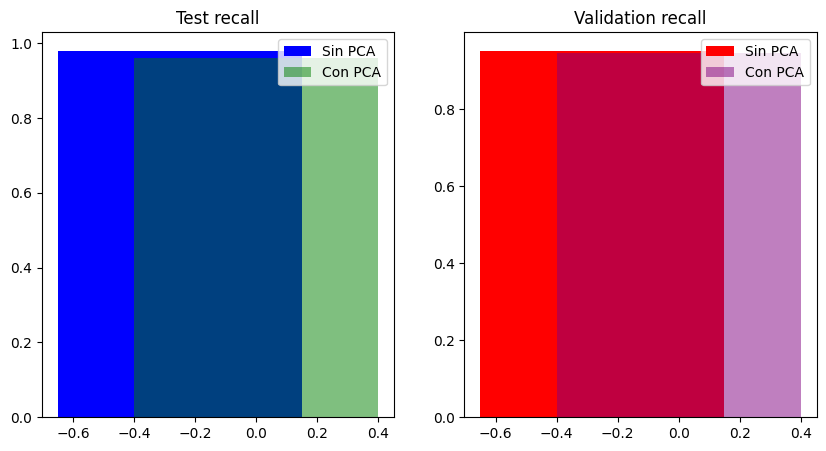

In [ ]:
# Crear los subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Crear un array de índices para las posiciones de las barras
x = np.arange(0.5)
width = 0.25

# Graficar las variables en las gráficas correspondientes
axs[0].bar(x - width,recall, color='blue', label='Sin PCA')
axs[0].bar(x,recall2, color='green', alpha=0.5, label='Con PCA')
axs[0].set_title('Test recall')
axs[0].legend()

axs[1].bar(x - width,val_recall, color='red', label='Sin PCA')
axs[1].bar(x,val_recall2, color='purple', alpha=0.5, label='Con PCA')
axs[1].set_title('Validation recall')
axs[1].legend()

# Mostrar la gráfica
plt.show()

Como se puede observar los resultados que se obtienen son mejores sin reducción de dimensionalidad, por lo que no se va a utilizar la PCA. 





##Elección del modelo de ML

Del estado del arte rescatamos los modelos de machine learning que podemos aplicar en los problemas de clasificación:

* La **regresión logística** es un método apropiado cuando la variable dependiente es binaria. 
Se utiliza para explicar la relación entre una variable dependiente y una o más variables 
independientes. Sus ventajas es que es un método sencillo, no suele haber sobreajuste y 
es rápido y sencillo de entrenar. Sus puntos negativos son que a veces es muy simple 
para captar relaciones complejas entre variables y puede no ser adecuado si existen 
anomalías en los datos. 
* El **algoritmo K-Nearest Neighbor** está basado en la similitud de características. Sus 
ventajas son que es simple, potente y rápido de entrenar, pero no es el algoritmo más 
adecuado cuando el conjunto de datos tiene una gran dimensionalidad y hay que definir 
de forma adecuada la distancia entre conjuntos. 
* Las **Máquinas de Vectores Soporte** (Support Vector Machines, SVM) se basan en la 
construcción de un hiperplano que separa los datos en diferentes clases. Sus ventajas 
son que puede modelar relaciones complejas en los datos y es robusto al ruido, pero se 
necesita definir de forma adecuada el kernel (hiperplano de separación) y además 
requiere de gran memoria y poder de procesamiento. 

* **Naive Bayes** es un modelo probabilístico que se basa en el teorema de Bayes. Es fácil y 
rápido de implementar, no requiere de mucha memoria y es sencillo de entender. No es 
adecuado si el conjunto de datos posee características irrelevantes o poco comunes. 
* Los **arboles de decisión** para clasificación se fabrican mediante diagramas de 
construcción lógica. Separan los datos de forma sucesiva en base a sus características, 
quedando una forma de árbol por niveles. Sus ventajas es que es fácil de interpretar, es 
robusto al ruido, preciso y muy bueno para aprender relaciones complejas. Para datos 
complejos puede no ser el mejor algoritmo. 
* **El random forest** consiste en una combinación de varios árboles de decisión. Sus 
ventajas son su capacidad de trabajar en paralelo, no suele haber overfitting 
(sobreajuste) y sus resultados suelen ser bastante buenos, pero puede ser difícil de 
interpretar. 

Los modelos anteriores podemos separarlos en modelos de caja blanca y caja negra. Los modelos de caja blanca son aquellos que permiten una mayor interpretación de cómo se llega a la predicción, mientras que los modelos de caja negra son aquellos que proporcionan resultados precisos pero pueden no ser tan fáciles de interpretar.

**Modelos de caja blanca**:

* Regresión logística
* Árbol de decisión

**Modelos de caja negra:**

* K-nearest-neighbor
* Support Vector Machine (SVM)
* Naive Bayes
* Random Forest

Para obtener un mejor detalle de cómo se realiza la clasificación lo mejor es utilizar modelos de caja blanca. Vamos a probar con la regresión logística y el árbol de clasificación y si se obtienen buenos resultados daremos el modelo por válido. 

###Regresión Logística

Primero realizamos una búsqueda de hiperparámetros

solver{‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’}, default=’lbfgs’

Algorithm to use in the optimization problem. Default is ‘lbfgs’. To choose a solver, you might want to consider the following aspects:

For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones;

For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss;

‘liblinear’ is limited to one-versus-rest schemes.

‘newton-cholesky’ is a good choice for n_samples >> n_features, especially with one-hot encoded categorical features with rare categories. Note that it is limited to binary classification and the one-versus-rest reduction for multiclass classification. Be aware that the memory usage of this solver has a quadratic dependency on n_features because it explicitly computes the Hessian matrix.

In [ ]:
model = LogisticRegression( max_iter=1000)



grid={"C": [0.001, 0.01, 0.1, 1, 10, 100], "solver":["sag", "saga"]}

grid_search = GridSearchCV(estimator = model,  
                           param_grid = grid,
                           scoring = 'accuracy',
                           cv = 5,
                           verbose=0)


grid_search.fit(X_train_sm, Y_train_sm) 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'solver': ['sag', 'saga']},
             scoring='accuracy')

In [ ]:
# Mostrar los mejores hiperparámetros encontrados
print('Mejores hiperparámetros encontrados:\n', grid_search.best_params_)
print('Puntaje de precisión: {:.2f}'.format(grid_search.best_score_))

Mejores hiperparámetros encontrados:
 {'C': 0.001, 'solver': 'sag'}
Puntaje de precisión: 0.75


Creamos el modelo

In [ ]:
log1 = LogisticRegression(solver='sag', C=0.001, max_iter=1000)

Lo entrenamos

In [ ]:
#Entreno el modelo
log1.fit(X_train_sm, Y_train_sm)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(C=0.001, max_iter=1000, solver='sag')

Probamos el modelo con los datos de test y de validacion y obtenemos las métricas de evaluación

In [ ]:
y_pred_test3=log1.predict(X_test_sm)
y_pred_val3=log1.predict(X_val_sm)

Test Accuracy: 0.7986348122866894
Test Recall: 0.9483870967741935
Validation Accuracy: 0.7831325301204819
Validation Recall: 0.9027777777777778
Matriz de confusión:


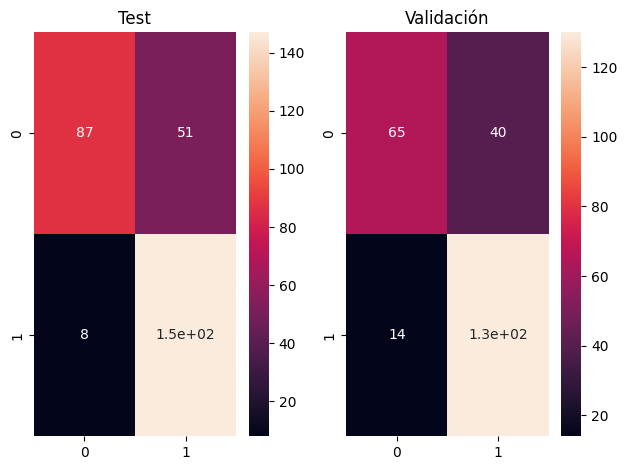

In [ ]:
# Evaluamos la prediccion utilizando las metricas
acc3=accuracy_score(Y_test_sm, y_pred_test3)
recall3=recall_score(Y_test_sm, y_pred_test3)
conf_mat3=confusion_matrix(Y_test_sm,y_pred_test3)

val_acc3 = accuracy_score(Y_val_sm, y_pred_val3)
val_recall3=recall_score(Y_val_sm, y_pred_val3)
val_conf_mat3=confusion_matrix(Y_val_sm,y_pred_val3)


print("Test Accuracy: {}".format(acc3))
print("Test Recall: {}".format(recall3))
print("Validation Accuracy: {}".format(val_acc3))
print("Validation Recall: {}".format(val_recall3))

print("Matriz de confusión:")

fig, axs = plt.subplots(1, 2)

sns.heatmap(conf_mat3, annot=True, ax=axs[0])
axs[0].set_title('Test')

sns.heatmap(val_conf_mat3, annot=True, ax=axs[1])
axs[1].set_title('Validación')

plt.tight_layout()
plt.show()

###Comparativa Regresión Logística vs Árbol de Clasificación

Ahora comparamos los resultados de la regresión logística con los obtenidos con el modelo del árbol de regresión (ambos modelos sin reducción de la dimensionalidad)

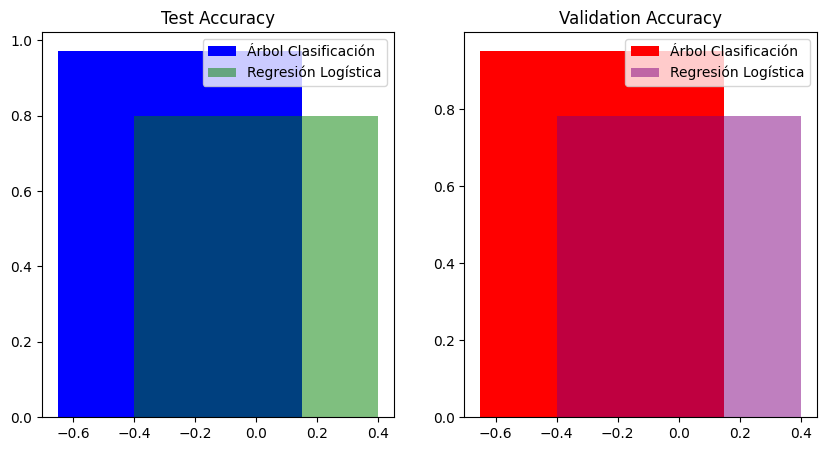

In [ ]:
# Crear los subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Crear un array de índices para las posiciones de las barras
x = np.arange(0.5)
width = 0.25

# Graficar las variables en las gráficas correspondientes
axs[0].bar(x - width,acc, color='blue', label='Árbol Clasificación')
axs[0].bar(x,acc3, color='green', alpha=0.5, label='Regresión Logística')
axs[0].set_title('Test Accuracy')
axs[0].legend()

axs[1].bar(x - width,val_acc, color='red', label='Árbol Clasificación')
axs[1].bar(x,val_acc3, color='purple', alpha=0.5, label='Regresión Logística')
axs[1].set_title('Validation Accuracy')
axs[1].legend()

# Mostrar la gráfica
plt.show()

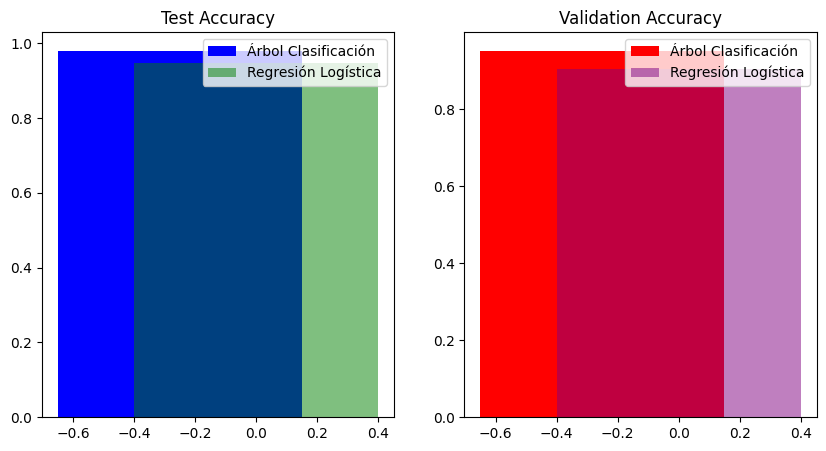

In [ ]:
# Crear los subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Crear un array de índices para las posiciones de las barras
x = np.arange(0.5)
width = 0.25

# Graficar las variables en las gráficas correspondientes
axs[0].bar(x - width,recall, color='blue', label='Árbol Clasificación')
axs[0].bar(x,recall3, color='green', alpha=0.5, label='Regresión Logística')
axs[0].set_title('Test Accuracy')
axs[0].legend()

axs[1].bar(x - width,val_recall, color='red', label='Árbol Clasificación')
axs[1].bar(x,val_recall3, color='purple', alpha=0.5, label='Regresión Logística')
axs[1].set_title('Validation Accuracy')
axs[1].legend()

# Mostrar la gráfica
plt.show()

Como se puede observar, son mucho mejores los resultados del árbol de clasificación, con lo que se va a utilziar dicho modelo para realizar la clasificación de empresas de alto crecimiento


##Startups fuera del modelo 

In [46]:
no_modelo=data2[data2['ALTO_CRECIMIENTO_CALCU']==0]

In [47]:
#otras columnas a eliminar
no_modelo.drop(columns=['GACELA_CALCU', 'MODELO_CALCU', 'CNAE_DESCRIPCION', 'ID', 'ORGANISMO'], axis=1, inplace=True)

<ipython-input-47-d5ff09ac36f8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_modelo.drop(columns=['GACELA_CALCU', 'MODELO_CALCU', 'CNAE_DESCRIPCION', 'ID', 'ORGANISMO'], axis=1, inplace=True)


In [48]:
no_modelo2=pd.get_dummies(no_modelo)

Vemos que el número de características sea igual al de los datos de entrenamiento

In [49]:
cols1=list(modelo2.columns)
cols2=list(no_modelo2)
print(len(cols1), len(cols2))

160 161


In [50]:
diff = list(set(cols2) - set(cols1))
print(diff)

['TAM_EMPRESA_Sin dato']


Los datos nunca vistos tienen una columna más que es TAM_EMPRESA_Sin dato, esto es a la conversión a dummies, que al tener un valor más en la columna TAM_EMPRESA, este valor lo transforma a columna. 

Vamos a ver qué valores hay y cuántas empresas tienen este campo 'Sin dato'

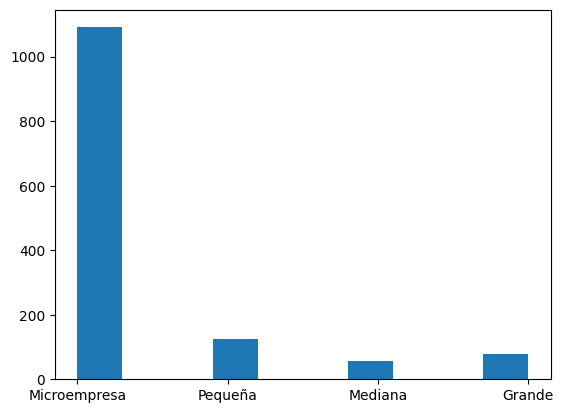

In [ ]:
plt.hist(modelo_clasif['TAM_EMPRESA'])
plt.show()

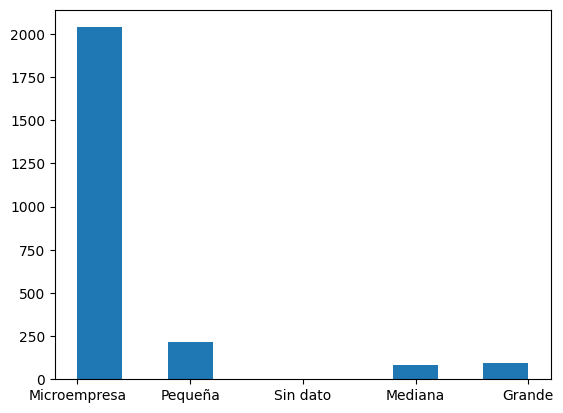

In [ ]:
plt.hist(no_modelo['TAM_EMPRESA'])
plt.show()

Como se puede observar, el número de empresas con TAM_EMPRESA = Sin dato es casi nulo, por lo que vamos a eliminar esta columna

In [51]:
no_modelo2.drop(columns=['TAM_EMPRESA_Sin dato'], inplace=True, axis=1)

Separamos los datos independientes de la target:

In [52]:
columnas2 = list(no_modelo2.columns)
columnas2.remove("ALTO_CRECIMIENTO_CALCU") 
X2 = no_modelo2[columnas2].values
# Variable a predecir: 
Y2 = no_modelo2['ALTO_CRECIMIENTO_CALCU']

In [22]:
# Check for infinite values
print(np.isfinite(X2).all())

False


In [54]:
X2 = np.nan_to_num(X2, nan=0, posinf=1e9, neginf=-1e9)
scaler = MinMaxScaler()
X2_scaled = scaler.fit_transform(X2)

En este caso no aplica utilizar una técnica de desbalanceo de datos

In [55]:
# Realizamos la predicción
y_pred_final = class_tree1.predict(X2_scaled)

In [56]:
no_modelo2.drop(columns=['ALTO_CRECIMIENTO_CALCU'], axis=1, inplace=True)

In [57]:
no_modelo2['ALTO_CRECIMIENTO_PRED']=y_pred_final

In [58]:
print('Número de empresas de alto crecimiento ', len(no_modelo2[no_modelo2['ALTO_CRECIMIENTO_PRED']==1]), ' de un total de ', len(no_modelo2), ' empresas')

Número de empresas de alto crecimiento  40  de un total de  1796  empresas


Text(0.5, 1.0, 'Alto Crecimiento')

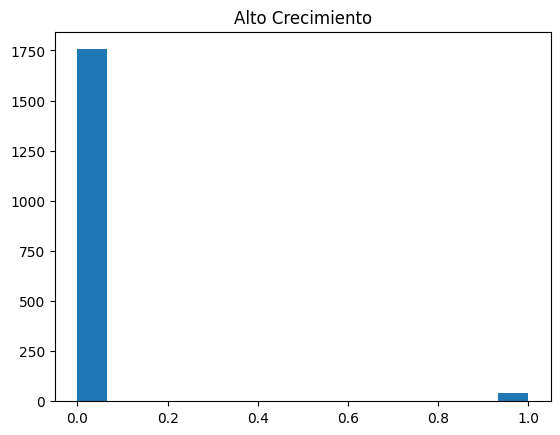

In [59]:
plt.hist(no_modelo2['ALTO_CRECIMIENTO_PRED'], bins = 15)
plt.title('Alto Crecimiento')

##Descarga de dataset

In [60]:
no_modelo2.to_csv('no_modelo_altoCrec.csv')